## BIRDCLEF 2024 - Rami El Wazzi & Sacha Guenoun

### Partie 3 - Training

#### Objectif du projet : entrainer un réseau de neurones permettant de reconnaitre un oiseau grâce à son cri.

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

### Chargement des propriétés du signal calculées en partie 2

In [3]:
X = np.load("../X.npy")
y = np.load("../y.npy")
df_train = pd.read_csv("../birdclef-2024/train_metadata.csv")[["primary_label", "filename"]]

FileNotFoundError: [Errno 2] No such file or directory: './birdclef-2024/train_metadata.csv'

In [ ]:
X.shape

(24459, 684)

In [ ]:
# concatenate X to df_train

df_train["X"] = X.tolist()

# def get_max_audio_length(file_paths):
#     max_length = 0
#     for file_path in file_paths:
#         y, sr = librosa.load(file_path, sr=None)
#         length = len(y)
#         if length > max_length:
#             max_length = length
#     return max_length

# file_paths = df_train['filename'].apply(lambda x: "./birdclef-2024/train_audio/" + x).tolist()

# max_length = get_max_audio_length(file_paths)
# print(f"The maximum length of the audio files is: {max_length} samples")
max_length = 190855200 # already calculated


In [ ]:
df_train

,primary_label,filename,X
0,asbfly,asbfly/XC134896.ogg,"[-79.97372436523438, -79.92324829101562, -79.5..."
1,asbfly,asbfly/XC164848.ogg,"[-15.896378517150879, -16.278581619262695, -16..."
2,asbfly,asbfly/XC175797.ogg,"[-58.841304779052734, -53.871551513671875, -55..."
3,asbfly,asbfly/XC207738.ogg,"[-18.35483741760254, -15.606270790100098, -16...."
4,asbfly,asbfly/XC209218.ogg,"[-14.528952598571777, -8.531251907348633, -9.6..."
...,...,...,...
24454,zitcis1,zitcis1/XC845747.ogg,"[-10.991899490356445, -12.973498344421387, -17..."
24455,zitcis1,zitcis1/XC845817.ogg,"[-9.823176383972168, -15.329643249511719, -24...."
24456,zitcis1,zitcis1/XC856176.ogg,"[-26.30453872680664, -12.45651626586914, -8.18..."
24457,zitcis1,zitcis1/XC856723.ogg,"[-24.176374435424805, -19.10907745361328, -18...."


In [ ]:
X.shape

(24459, 684)

In [ ]:
len(df_train["X"]), len(df_train["X"].iloc[0])

(24459, 684)

### Après plusieurs essais tests, nous décidons d'entrainer un CNN contenant l'image du spectrogramme (partie 1) ET les propriétés du signal (partie 2) pour s'assurer la meilleure accuracy.

Chargement des images du spectrogramme

In [ ]:
# function to get the rgb spectrogram of the file in filename

import librosa

def get_spectrogram(filename):
    y, sr = librosa.load(filename, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

In [ ]:
class CFG:
    sample_rate = 32000
    nfft = 2028
    hop_length = 512
    fmin = 20
    fmax = 16000
    img_height = 128
    img_width = 128  # Fixed width for all spectrograms
    batch_size = 16  # Batch size for processing
    data_dir = './birdclef-2024/train_audio/'
    output_dir = './processed_spectrograms/'
    seed = 42
    patience = 10
    num_classes = 182
    epochs = 50

Optimisation de la mémoire en sauvegardant les images sous formes d'array numpy puis en fichiers .npy

In [ ]:
from tqdm.notebook import tqdm


# Ensure the output directory exists
os.makedirs(CFG.output_dir, exist_ok=True)

def get_spectrogram(filepath):
    audio, sr = librosa.load(filepath, sr=CFG.sample_rate)
    spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=CFG.img_height, n_fft=CFG.nfft, hop_length=CFG.hop_length, fmin=CFG.fmin, fmax=CFG.fmax)
    spec_db = librosa.power_to_db(spec, ref=np.max)
    return spec_db

# Process spectrograms in batches and save to disk
def process_and_save_spectrograms(df, batch_size):
    for start in tqdm(range(0, len(df), batch_size)):
        end = min(start + batch_size, len(df))
        batch = df.iloc[start:end]
        spectrograms = []
        for idx, row in batch.iterrows():
            os.makedirs(CFG.output_dir + row["filename"].split("/")[0], exist_ok=True)
            filepath = os.path.join(CFG.data_dir, row['filename'])
            spec = get_spectrogram(filepath)
            np.save(os.path.join(CFG.output_dir, f"{row['filename'].replace('.ogg', '.npy')}"), spec)
            spectrograms.append(spec)
        batch['spectrogram'] = spectrograms

# Assuming your DataFrame is named df_train
process_and_save_spectrograms(df_train, CFG.batch_size)

  0%|          | 0/383 [00:00<?, ?it/s]

/tmp/ipykernel_1010778/2065003648.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['spectrogram'] = spectrograms
/tmp/ipykernel_1010778/2065003648.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['spectrogram'] = spectrograms
/tmp/ipykernel_1010778/2065003648.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

#### On a besoin d'avoir tous les audios de la même longueur. La distortion nous faisant perdre l'information sur le rythme (voir partie 1), on décide de jouer l'audio en boucle sur le temps imparti.

In [ ]:
import numpy as np

def pad_or_loop_spectrogram(spectrogram, target_shape=(128, 128)):
    current_shape = spectrogram.shape
    if current_shape[1] < target_shape[1]:
        repeat_count = int(np.ceil(target_shape[1] / current_shape[1]))
        spectrogram = np.tile(spectrogram, (1, repeat_count))[:, :target_shape[1]]
    else:
        spectrogram = spectrogram[:, :target_shape[1]]
    return spectrogram


In [ ]:
# Convert string labels to categorical codes
df_train['label_code'] = pd.Categorical(df_train['primary_label']).codes

# Save the mapping for later use (if needed)
label_mapping = dict(enumerate(pd.Categorical(df_train['primary_label']).categories))


### Génération des données et entrainement du CNN. On a bien 2 branches : x représentant l'image et y représentant les propriétés du son (ici appellées métadonnées)

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import os

class DataGenerator(Sequence):
    def __init__(self, df, batch_size, img_shape, num_classes, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        return self.__data_generation(batch_df)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __data_generation(self, batch_df):
        X_img = np.empty((self.batch_size, *self.img_shape))
        X_meta = np.empty((self.batch_size, len(df_train['X'].iloc[0])))
        y = np.empty((self.batch_size), dtype=int)
        
        for i, (idx, row) in enumerate(batch_df.iterrows()):
            spectrogram = np.load(os.path.join(CFG.output_dir, f"{row['filename'].replace('.ogg', '.npy')}"))
            X_img[i,] = np.expand_dims(pad_or_loop_spectrogram(spectrogram, target_shape=self.img_shape[:2]), axis=-1)
            X_meta[i,] = np.array(row['X'])
            y[i] = row['label_code']
        
        return {'img_input': X_img, 'meta_input': X_meta}, to_categorical(y, num_classes=self.num_classes)

train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=CFG.seed)

train_generator = DataGenerator(train_df, batch_size=CFG.batch_size, img_shape=(CFG.img_height, CFG.img_width, 1), num_classes=len(df_train['primary_label'].unique()))
val_generator = DataGenerator(val_df, batch_size=CFG.batch_size, img_shape=(CFG.img_height, CFG.img_width, 1), num_classes=len(df_train['primary_label'].unique()))
print("a")
# Define the CNN model with metadata input and batch normalization

def build_cnn_model(img_shape, num_meta_features, num_classes):
    l2_reg = 0.001  # Regularization factor
    
    img_input = Input(shape=img_shape, name='img_input')
    x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_reg))(img_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    
    meta_input = Input(shape=(num_meta_features,), name='meta_input')
    y = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(meta_input)
    y = BatchNormalization()(y)
    y = Dropout(0.5)(y)
    y = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(y)
    y = BatchNormalization()(y)
    y = Dropout(0.5)(y)
    y = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg))(y)
    y = BatchNormalization()(y)
    
    combined = concatenate([x, y])
    z = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(combined)
    z = BatchNormalization()(z)
    z = Dropout(0.5)(z)
    z = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg))(z)
    
    model = Model(inputs=[img_input, meta_input], outputs=z)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


# Build the model
model = build_cnn_model((CFG.img_height, CFG.img_width, 1), len(df_train['X'].iloc[0]), len(df_train['primary_label'].unique()))

# Define early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_accuracy', patience=CFG.patience, restore_best_weights=True, mode='max')
checkpoint = ModelCheckpoint(filepath='best_model.weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', save_weights_only=True, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=CFG.epochs,
    callbacks=[early_stopping, checkpoint]
)

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f"Test Accuracy: {accuracy:.4f}")

# Load the best weights
model.load_weights('best_model.weights.h5')

# Re-evaluate the model with the best weights
loss, accuracy = model.evaluate(val_generator)
print(f"Test Accuracy with best weights: {accuracy:.4f}")


a
Epoch 1/50


/home/rel-wazzi/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1222/1222 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.0655 - loss: 6.2995
Epoch 1: val_accuracy improved from -inf to 0.15164, saving model to best_model.weights.h5
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 264s 214ms/step - accuracy: 0.0655 - loss: 6.2992 - val_accuracy: 0.1516 - val_loss: 5.4118
Epoch 2/50
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.1599 - loss: 5.4285
Epoch 2: val_accuracy improved from 0.15164 to 0.17725, saving model to best_model.weights.h5
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 265s 216ms/step - accuracy: 0.1599 - loss: 5.4285 - val_accuracy: 0.1773 - val_loss: 5.4885
Epoch 3/50
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.2006 - loss: 5.4639
Epoch 3: val_accuracy improved from 0.17725 to 0.18689, saving model to best_model.weights.h5
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 265s 217ms/step - accuracy: 0.2006 - loss: 5.4640 - val_accuracy: 0.1869 - val_loss: 5.7173
Epoch 4/50
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.2250 - loss: 5.4804
Epo

KeyboardInterrupt: 

# A PARTIR DE LA JE SAIS PAS A QUEL POINT C'EST L'HECATOMBE DONC JTE LAISSE VOIR RAMI

In [ ]:
# tqdm to apply this function to all the files in the dataframe and save the spectrograms in a new column

from tqdm.notebook import tqdm

tqdm.pandas()

df_train["spectrogram"] = df_train["filename"].progress_apply(lambda x: get_spectrogram("./birdclef-2024/train_audio/" + x))

df_train.to_csv("df_train.csv", index=False)

df_train


  0%|          | 0/24459 [00:00<?, ?it/s]

: 

In [ ]:
df_train[df_train["filename"]=="asbfly/XC134896.ogg"]["spectrogram"][0].shape

(128, 1710)

In [ ]:
get_spectrogram("./birdclef-2024/train_audio/asbfly/XC134896.ogg").shape

(128, 1710)

In [ ]:
X.shape

(24459, 684)

In [ ]:
df_train["spectrogram"].iloc[0]

array([[-80., -80., -80., ..., -80., -80., -80.],
       [-80., -80., -80., ..., -80., -80., -80.],
       [-80., -80., -80., ..., -80., -80., -80.],
       ...,
       [-80., -80., -80., ..., -80., -80., -80.],
       [-80., -80., -80., ..., -80., -80., -80.],
       [-80., -80., -80., ..., -80., -80., -80.]], dtype=float32)

In [ ]:
df_train["spectrogram"][2].shape

(128, 1829)

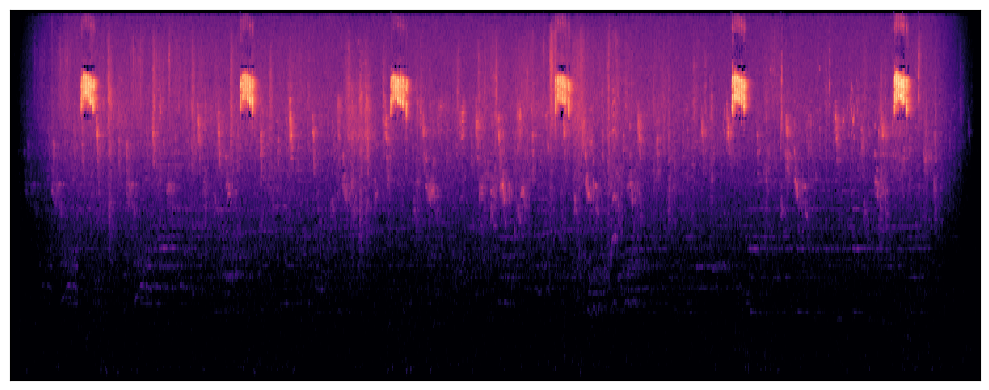

In [ ]:
# show the spectrogram as image

plt.figure(figsize=(10, 4))
librosa.display.specshow(df_train["spectrogram"][0])
plt.tight_layout()
plt.show()


In [ ]:
spect_shape = df_train["spectrogram"].apply(lambda x: x.shape[1])
# get the max length of the spectrograms

max_length_spect = spect_shape.max()
# index of the file with the max length
max_length_spect_idx = spect_shape.idxmax()
max_length_spect, max_length_spect_idx



(372765, 3699)

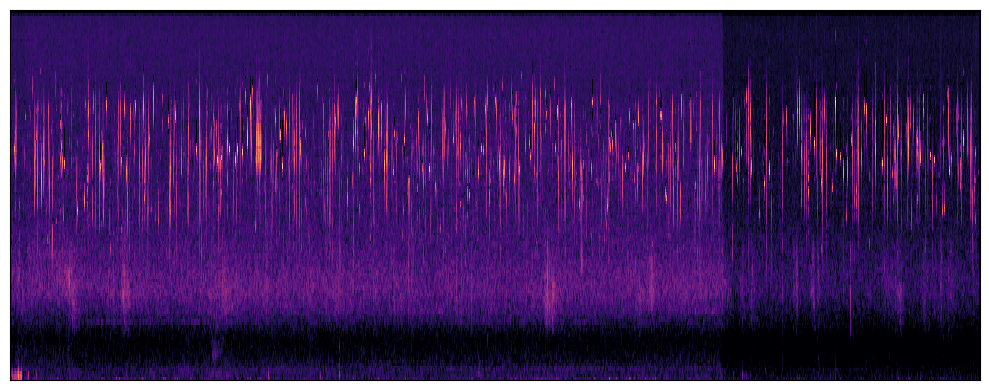

In [ ]:
# show the spectrogram as image
plt.figure(figsize=(10, 4))
librosa.display.specshow(df_train["spectrogram"][max_length_spect_idx])
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, concatenate, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Configuration class (ensure consistency)
class CFG:
    seed = 42
    img_height = 128
    img_width = max_length_spect  # Fixed width for all spectrograms
    channels = 1  # Using single channel for simplicity
    batch_size = 64
    sample_rate = 32000
    epochs = 200
    patience = 30

# Padding or looping spectrograms to a fixed size
def pad_or_loop_spectrogram(spectrogram, target_shape=(CFG.img_height, CFG.img_width)):
    current_shape = spectrogram.shape
    if current_shape[1] < target_shape[1]:
        repeat_count = int(np.ceil(target_shape[1] / current_shape[1]))
        spectrogram = np.tile(spectrogram, (1, repeat_count))[:, :target_shape[1]]
    else:
        spectrogram = spectrogram[:, :target_shape[1]]
    return spectrogram

# Load metadata
df = df_train.copy()  # Assuming your DataFrame is saved in a CSV file

# Prepare the spectrograms and additional features
spectrograms = []
features = []
labels = []

for _, row in df.iterrows():
    spec = pad_or_loop_spectrogram(row['spectrogram'])
    spectrograms.append(spec)
    features.append(row['X'])
    labels.append(row['primary_label'])

# Convert to numpy arrays
spectrograms = np.array(spectrograms)
spectrograms = spectrograms[..., np.newaxis]  # Add channel dimension
features = np.array(features)
labels = pd.Categorical(labels).codes
labels = to_categorical(labels)

# Standardize the additional features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split data into training and testing sets
X_train_img, X_test_img, X_train_meta, X_test_meta, y_train, y_test = train_test_split(
    spectrograms, features, labels, test_size=0.2, random_state=CFG.seed)

# Define the CNN model with metadata input and batch normalization
def build_cnn_model(img_shape, num_meta_features, num_classes):
    img_input = Input(shape=img_shape, name='img_input')
    x = Conv2D(32, (3, 3), activation='relu')(img_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    
    meta_input = Input(shape=(num_meta_features,), name='meta_input')
    y = Dense(256, activation='relu')(meta_input)
    y = BatchNormalization()(y)
    y = Dropout(0.5)(y)
    y = Dense(128, activation='relu')(y)
    y = BatchNormalization()(y)
    y = Dropout(0.5)(y)
    y = Dense(64, activation='relu')(y)
    y = BatchNormalization()(y)
    
    combined = concatenate([x, y])
    z = Dense(256, activation='relu')(combined)
    z = BatchNormalization()(z)
    z = Dense(num_classes, activation='softmax')(z)
    
    model = Model(inputs=[img_input, meta_input], outputs=z)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Build the model
model = build_cnn_model((CFG.img_height, CFG.img_width, CFG.channels), X_train_meta.shape[1], labels.shape[1])

# Define early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=CFG.patience, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True, verbose=1)




KeyboardInterrupt: 

In [ ]:
# Train the model
history = model.fit(
    {'img_input': X_train_img, 'meta_input': X_train_meta},
    y_train,
    epochs=CFG.epochs,
    batch_size=CFG.batch_size,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint]
)

# Evaluate the model
loss, accuracy = model.evaluate({'img_input': X_test_img, 'meta_input': X_test_meta}, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Load the best weights
model.load_weights('best_model.h5')

# Re-evaluate the model with the best weights
loss, accuracy = model.evaluate({'img_input': X_test_img, 'meta_input': X_test_meta}, y_test)
print(f"Test Accuracy with best weights: {accuracy:.4f}")

In [ ]:
df_train2 = df_train.copy()
